# Named Entity Recognition dengan BERT
## Dataset: Indonesian Universal Dependencies GSD

Notebook ini akan mengimplementasikan Named Entity Recognition (NER) menggunakan model BERT yang dilatih pada dataset Indonesian Universal Dependencies GSD dari https://universaldependencies.org/

### Tahapan:
1. Download dan preprocessing data CoNLL-U
2. Ekstraksi entitas dari annotasi Universal Dependencies
3. Persiapan data untuk training BERT
4. Training model BERT untuk NER
5. Evaluasi dan testing model

In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [2]:
# !pip install transformers[torch]

In [3]:
# Install required libraries
# !pip install transformers torch torchvision torchaudio
# !pip install datasets
# !pip install seqeval
# !pip install requests
# !pip install pandas numpy matplotlib seaborn
# !pip install scikit-learn


In [4]:
# # Uninstall current PyTorch and reinstall with CUDA support
# !pip uninstall torch torchvision torchaudio -y

In [5]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=b01e162db5056f5a20ba8427dea99088cd95185142906813e408075e42bc2748
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [6]:
import torch
print(f"PyTorch dibuat dengan CUDA versi: {torch.version.cuda}")

PyTorch dibuat dengan CUDA versi: 12.4


In [7]:
import os
import re
import requests
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForTokenClassification,
    # TrainingArguments,
    # Trainer,
    DataCollatorForTokenClassification
)
from datasets import Dataset as HFDataset
from seqeval.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

2025-06-24 13:08:24.407775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750770504.622199      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750770504.685223      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [8]:
# URLs for Indonesian Universal Dependencies GSD dataset
urls = {
    'train': 'https://raw.githubusercontent.com/UniversalDependencies/UD_Indonesian-GSD/refs/heads/master/id_gsd-ud-train.conllu',
    'test': 'https://raw.githubusercontent.com/UniversalDependencies/UD_Indonesian-GSD/refs/heads/master/id_gsd-ud-test.conllu',
    'dev': 'https://raw.githubusercontent.com/UniversalDependencies/UD_Indonesian-GSD/refs/heads/master/id_gsd-ud-dev.conllu'
}

def download_conllu_data(url, filename):
    """Download CoNLL-U file from URL"""
    print(f"Downloading {filename}...")
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(response.text)
        print(f"Successfully downloaded {filename}")
        return True
    else:
        print(f"Failed to download {filename}. Status code: {response.status_code}")
        return False

# Download all files
for split, url in urls.items():
    filename = f"id_gsd-ud-{split}.conllu"
    download_conllu_data(url, filename)

Successfully downloaded id_gsd-ud-train.conllu
Successfully downloaded id_gsd-ud-test.conllu
Successfully downloaded id_gsd-ud-dev.conllu


In [9]:
def parse_conllu_file(filename):
    """
    Parse CoNLL-U file and extract sentences with NER labels
    Returns list of sentences, each containing list of (word, pos_tag, ner_tag) tuples
    """
    sentences = []
    current_sentence = []
    
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            
            # Skip comments and empty lines
            if line.startswith('#') or not line:
                if current_sentence:
                    sentences.append(current_sentence)
                    current_sentence = []
                continue
            
            # Parse CoNLL-U format
            parts = line.split('\t')
            if len(parts) >= 10:
                token_id = parts[0]
                
                # Skip multi-word tokens (contains '-')
                if '-' in token_id or '.' in token_id:
                    continue
                
                word = parts[1]
                pos_tag = parts[3]  # UPOS
                misc = parts[9]     # MISC column might contain NER info
                
                # Extract NER information from MISC field or create based on POS tags
                ner_tag = extract_ner_from_misc(misc, pos_tag)
                
                current_sentence.append((word, pos_tag, ner_tag))
    
    # Add the last sentence if it exists
    if current_sentence:
        sentences.append(current_sentence)
    
    return sentences

def extract_ner_from_misc(misc, pos_tag):
    """
    Extract NER tags from MISC field or create based on POS tags
    Since Universal Dependencies doesn't have standard NER tags,
    we'll create them based on POS tags and patterns
    """
    # Check if there's SpaceAfter=No or other info
    if misc and misc != '_':
        # Look for any NER-like annotations
        if 'NER=' in misc:
            return misc.split('NER=')[1].split('|')[0]
    
    # Create NER tags based on POS tags for common entity types
    if pos_tag == 'PROPN':  # Proper noun
        return 'B-PER'  # Default to person, can be refined later
    elif pos_tag == 'NUM':
        return 'B-NUM'
    else:
        return 'O'  # Outside any entity

def create_ner_tags_from_pos(sentences):
    """
    Create more sophisticated NER tags based on POS patterns and context
    """
    processed_sentences = []
    
    for sentence in sentences:
        processed_sentence = []
        prev_pos = None
        
        for i, (word, pos_tag, _) in enumerate(sentence):
            # Better NER tag assignment based on patterns
            if pos_tag == 'PROPN':
                # Check if it's likely a person name (following patterns)
                if i > 0 and sentence[i-1][1] == 'PROPN':
                    ner_tag = 'I-PER'  # Inside person name
                elif (i < len(sentence) - 1 and sentence[i+1][1] == 'PROPN'):
                    ner_tag = 'B-PER'  # Beginning of person name
                else:
                    # Single proper noun - could be person, location, or organization
                    if any(indicator in word.lower() for indicator in ['jakarta', 'indonesia', 'surabaya', 'bandung']):
                        ner_tag = 'B-LOC'
                    elif any(indicator in word.lower() for indicator in ['universitas', 'sekolah', 'rumah sakit', 'bank']):
                        ner_tag = 'B-ORG'
                    else:
                        ner_tag = 'B-PER'
            elif pos_tag == 'NUM':
                ner_tag = 'B-NUM'
            else:
                ner_tag = 'O'
            
            processed_sentence.append((word, pos_tag, ner_tag))
            prev_pos = pos_tag
        
        processed_sentences.append(processed_sentence)
    
    return processed_sentences

# Parse all files
data = {}
for split in ['train', 'dev', 'test']:
    filename = f"id_gsd-ud-{split}.conllu"
    print(f"Parsing {filename}...")
    sentences = parse_conllu_file(filename)
    # Create NER tags from POS patterns
    sentences = create_ner_tags_from_pos(sentences)
    data[split] = sentences
    print(f"Found {len(sentences)} sentences in {split} set")

print("\\nData loading complete!")

Parsing id_gsd-ud-train.conllu...
Found 4482 sentences in train set
Parsing id_gsd-ud-dev.conllu...
Found 559 sentences in dev set
Parsing id_gsd-ud-test.conllu...
Found 557 sentences in test set
\nData loading complete!


In [10]:
# Data exploration
print("Dataset Statistics:")
print("=" * 50)

# Count sentences and tokens in each split
for split, sentences in data.items():
    total_tokens = sum(len(sentence) for sentence in sentences)
    print(f"{split.upper()} set:")
    print(f"  - Sentences: {len(sentences)}")
    print(f"  - Tokens: {total_tokens}")
    print(f"  - Average tokens per sentence: {total_tokens/len(sentences):.2f}")

# Analyze NER tag distribution
print("\nNER Tag Distribution:")
print("=" * 50)

all_tags = []
for split, sentences in data.items():
    split_tags = [tag for sentence in sentences for _, _, tag in sentence]
    tag_counts = Counter(split_tags)
    print(f"\n{split.upper()} set:")
    for tag, count in tag_counts.most_common():
        percentage = (count / len(split_tags)) * 100
        print(f"  {tag}: {count} ({percentage:.2f}%)")
    all_tags.extend(split_tags)

# Overall tag distribution
overall_tag_counts = Counter(all_tags)
print(f"\nOVERALL:")
for tag, count in overall_tag_counts.most_common():
    percentage = (count / len(all_tags)) * 100
    print(f"  {tag}: {count} ({percentage:.2f}%)")

# Create unique labels list for model
unique_labels = list(overall_tag_counts.keys())
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"\nUnique NER labels: {unique_labels}")
print(f"Number of labels: {len(unique_labels)}")

Dataset Statistics:
TRAIN set:
  - Sentences: 4482
  - Tokens: 97602
  - Average tokens per sentence: 21.78
DEV set:
  - Sentences: 559
  - Tokens: 12661
  - Average tokens per sentence: 22.65
TEST set:
  - Sentences: 557
  - Tokens: 11756
  - Average tokens per sentence: 21.11

NER Tag Distribution:

TRAIN set:
  O: 76190 (78.06%)
  B-PER: 11110 (11.38%)
  I-PER: 6462 (6.62%)
  B-NUM: 3478 (3.56%)
  B-LOC: 356 (0.36%)
  B-ORG: 6 (0.01%)

DEV set:
  O: 9934 (78.46%)
  B-PER: 1449 (11.44%)
  I-PER: 827 (6.53%)
  B-NUM: 405 (3.20%)
  B-LOC: 43 (0.34%)
  B-ORG: 3 (0.02%)

TEST set:
  O: 9209 (78.33%)
  B-PER: 1334 (11.35%)
  I-PER: 790 (6.72%)
  B-NUM: 385 (3.27%)
  B-LOC: 37 (0.31%)
  B-ORG: 1 (0.01%)

OVERALL:
  O: 95333 (78.13%)
  B-PER: 13893 (11.39%)
  I-PER: 8079 (6.62%)
  B-NUM: 4268 (3.50%)
  B-LOC: 436 (0.36%)
  B-ORG: 10 (0.01%)

Unique NER labels: ['B-PER', 'O', 'I-PER', 'B-LOC', 'B-NUM', 'B-ORG']
Number of labels: 6


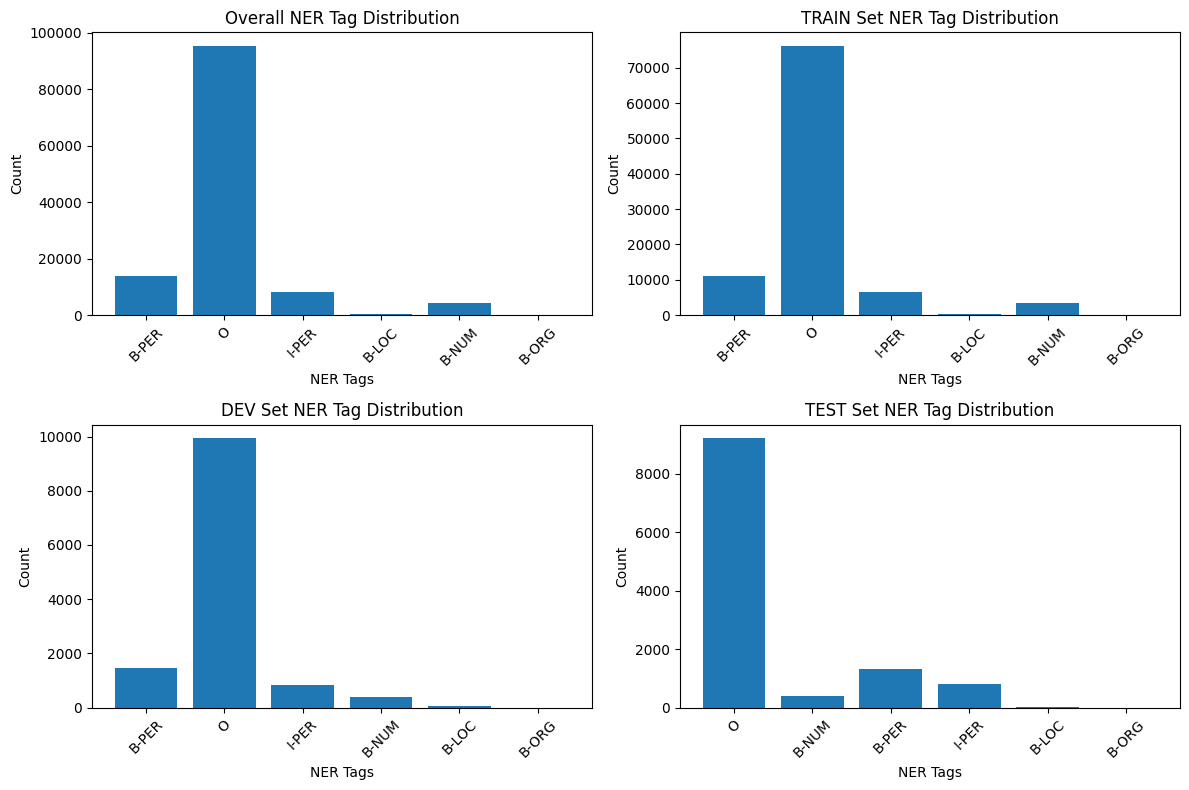


Sample sentences with NER tags:

Sentence 1:
  Sembungan       | PROPN    | B-PER
  adalah          | AUX      | O
  sebuah          | DET      | O
  desa            | NOUN     | O
  yang            | PRON     | O
  terletak        | VERB     | O
  di              | ADP      | O
  kecamatan       | NOUN     | O
  Kejajar         | PROPN    | B-PER
  ,               | PUNCT    | O
  kabupaten       | NOUN     | O
  Wonosobo        | PROPN    | B-PER
  ,               | PUNCT    | O
  Jawa            | PROPN    | B-PER
  Tengah          | PROPN    | I-PER
  ,               | PUNCT    | O
  Indonesia       | PROPN    | B-LOC
  .               | PUNCT    | O

Sentence 2:
  Sebuah          | DET      | O
  serangan        | NOUN     | O
  pengayauan      | NOUN     | O
  biasanya        | ADV      | O
  terjadi         | VERB     | O
  di              | ADP      | O
  ladang          | NOUN     | O
  atau            | CCONJ    | O
  dengan          | SCONJ    | O
  membakar        | VERB  

In [11]:
# Visualize NER tag distribution
plt.figure(figsize=(12, 8))

# Plot overall tag distribution
tags = list(overall_tag_counts.keys())
counts = list(overall_tag_counts.values())

plt.subplot(2, 2, 1)
plt.bar(tags, counts)
plt.title('Overall NER Tag Distribution')
plt.xlabel('NER Tags')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot distribution for each dataset split
for i, split in enumerate(['train', 'dev', 'test'], 2):
    split_tags = [tag for sentence in data[split] for _, _, tag in sentence]
    split_counts = Counter(split_tags)
    
    plt.subplot(2, 2, i)
    plt.bar(split_counts.keys(), split_counts.values())
    plt.title(f'{split.upper()} Set NER Tag Distribution')
    plt.xlabel('NER Tags')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Show sample sentences
print("\nSample sentences with NER tags:")
print("=" * 50)
for i, sentence in enumerate(data['train'][:3]):
    print(f"\nSentence {i+1}:")
    for word, pos, ner in sentence:
        print(f"  {word:15} | {pos:8} | {ner}")

In [12]:
from transformers import AutoTokenizer
class NERDataset(Dataset):
    def __init__(self, sentences, tokenizer, label2id, max_length=128):
        self.sentences = sentences
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_length = max_length
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        words = [word for word, _, _ in sentence]
        labels = [label for _, _, label in sentence]
        
        # Tokenize words and align labels
        tokenized_inputs = self.tokenizer(
            words,
            truncation=True,
            is_split_into_words=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Align labels with tokenized inputs
        word_ids = tokenized_inputs.word_ids()
        aligned_labels = []
        previous_word_idx = None
        
        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(-100)  # Special token
            elif word_idx != previous_word_idx:
                aligned_labels.append(self.label2id[labels[word_idx]])
            else:
                aligned_labels.append(-100)  # Sub-word token
            previous_word_idx = word_idx
        
        return {
            'input_ids': tokenized_inputs['input_ids'].flatten(),
            'attention_mask': tokenized_inputs['attention_mask'].flatten(),
            'labels': torch.tensor(aligned_labels, dtype=torch.long)
        }

def prepare_data_for_training(data, tokenizer, label2id):
    """Prepare datasets for training"""
    datasets = {}
    
    for split in ['train', 'dev', 'test']:
        datasets[split] = NERDataset(
            sentences=data[split],
            tokenizer=tokenizer,
            label2id=label2id,
            max_length=128
        )
        print(f"Created {split} dataset with {len(datasets[split])} examples")
    
    return datasets

# Initialize Indonesian BERT tokenizer
model_name = "indolem/indobert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, ignore_mismatched_sizes=True)

# Prepare datasets
datasets = prepare_data_for_training(data, tokenizer, label2id)

print(f"\\nTokenizer vocab size: {tokenizer.vocab_size}")
print(f"Model will be trained on {len(unique_labels)} NER labels")

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Created train dataset with 4482 examples
Created dev dataset with 559 examples
Created test dataset with 557 examples
\nTokenizer vocab size: 31923
Model will be trained on 6 NER labels


In [13]:
from transformers import TrainingArguments, AutoModelForTokenClassification

# Initialize the model
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)

# Move model to device
model.to(device)

# Data collator for token classification
data_collator = DataCollatorForTokenClassification(tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1',
    greater_is_better=True,
    save_total_limit=2,
    report_to=None,
)

# Define evaluation metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)
    
    # Convert to list of lists, removing special tokens (-100)
    true_labels = []
    pred_labels = []
    
    for i in range(labels.shape[0]):
        true_label_ids = []
        pred_label_ids = []
        
        for j in range(labels.shape[1]):
            if labels[i, j] != -100:
                true_label_ids.append(id2label[labels[i, j]])
                pred_label_ids.append(id2label[predictions[i, j]])
        
        true_labels.append(true_label_ids)
        pred_labels.append(pred_label_ids)
    
    # Calculate metrics using seqeval
    accuracy = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    
    return {
        'accuracy': accuracy,
        'f1': f1
    }

print(f"Model initialized with {model.num_parameters()} parameters")
print(f"Training on {len(datasets['train'])} examples")
print(f"Validation on {len(datasets['dev'])} examples")

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Model initialized with 109972230 parameters
Training on 4482 examples
Validation on 559 examples


In [14]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets['train'],
    eval_dataset=datasets['dev'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Start training
print("Starting training...")
trainer.train()

# Save the model
trainer.save_model('./fine_tuned_bert_ner')
print("Model saved to './fine_tuned_bert_ner'")

/tmp/ipykernel_19/1959123229.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.868500,0.232590,0.920152,0.717974
2,0.227400,0.146285,0.949044,0.825881
3,0.116200,0.165657,0.945075,0.820551


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Model saved to './fine_tuned_bert_ner'


In [15]:
# Evaluate on test set
print("Evaluating on test set...")
test_results = trainer.evaluate(datasets['test'])
print("Test Results:")
for key, value in test_results.items():
    print(f"  {key}: {value:.4f}")

# Get predictions on test set
predictions = trainer.predict(datasets['test'])
y_pred = np.argmax(predictions.predictions, axis=2)
y_true = predictions.label_ids

# Convert predictions to labels for detailed analysis
def get_predictions_and_labels(y_pred, y_true, id2label):
    pred_labels = []
    true_labels = []
    
    for i in range(y_pred.shape[0]):
        pred_sentence = []
        true_sentence = []
        
        for j in range(y_pred.shape[1]):
            if y_true[i, j] != -100:
                pred_sentence.append(id2label[y_pred[i, j]])
                true_sentence.append(id2label[y_true[i, j]])
        
        if pred_sentence:  # Only add non-empty sentences
            pred_labels.append(pred_sentence)
            true_labels.append(true_sentence)
    
    return pred_labels, true_labels

pred_labels, true_labels = get_predictions_and_labels(y_pred, y_true, id2label)

# Detailed classification report
print("\\nDetailed Classification Report:")
print("=" * 80)
print(classification_report(true_labels, pred_labels, digits=4))

Evaluating on test set...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test Results:
  eval_loss: 0.1296
  eval_accuracy: 0.9541
  eval_f1: 0.8495
  eval_runtime: 3.0203
  eval_samples_per_second: 184.4220
  eval_steps_per_second: 5.9600
  epoch: 3.0000
\nDetailed Classification Report:
              precision    recall  f1-score   support

         LOC     0.9459    0.9459    0.9459        37
         NUM     0.9661    0.9815    0.9738       378
         ORG     0.0000    0.0000    0.0000         1
         PER     0.8123    0.8104    0.8113      1324

   micro avg     0.8490    0.8500    0.8495      1740
   macro avg     0.6811    0.6845    0.6828      1740
weighted avg     0.8481    0.8500    0.8490      1740



/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
def predict_ner(text, model, tokenizer, id2label, max_length=128):
    """
    Predict NER tags for a given text
    """
    # Tokenize the input text
    inputs = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    
    # Move inputs to device
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Get model predictions
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
    
    # Convert predictions to labels
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    predicted_labels = [id2label[pred.item()] for pred in predictions[0]]
    
    # Filter out special tokens and align with original text
    results = []
    for token, label in zip(tokens, predicted_labels):
        if token not in ['[CLS]', '[SEP]', '[PAD]']:
            results.append((token, label))
    
    return results

# Test the model with some example sentences
test_sentences = [
    "Saya tinggal di Jakarta, Indonesia.",
    "Budi bekerja di Universitas Indonesia.",
    "Pada tahun 2023, pemerintah Indonesia mengeluarkan kebijakan baru.",
    "PT Telkom Indonesia adalah perusahaan telekomunikasi terbesar di Indonesia."
]

print("Testing the trained model:")
print("=" * 80)

for i, sentence in enumerate(test_sentences, 1):
    print(f"\\nExample {i}: {sentence}")
    print("-" * 40)
    
    predictions = predict_ner(sentence, model, tokenizer, id2label)
    
    for token, label in predictions:
        if label != 'O':  # Only show non-O labels
            print(f"  {token:15} -> {label}")
    
    # Show all predictions
    print("  All predictions:")
    for token, label in predictions:
        print(f"    {token:15} | {label}")

Testing the trained model:
\nExample 1: Saya tinggal di Jakarta, Indonesia.
----------------------------------------
  jakarta         -> B-LOC
  indonesia       -> B-LOC
  All predictions:
    saya            | O
    tinggal         | O
    di              | O
    jakarta         | B-LOC
    ,               | O
    indonesia       | B-LOC
    .               | O
\nExample 2: Budi bekerja di Universitas Indonesia.
----------------------------------------
  budi            -> B-PER
  universitas     -> B-PER
  indonesia       -> I-PER
  All predictions:
    budi            | B-PER
    bekerja         | O
    di              | O
    universitas     | B-PER
    indonesia       | I-PER
    .               | O
\nExample 3: Pada tahun 2023, pemerintah Indonesia mengeluarkan kebijakan baru.
----------------------------------------
  202             -> B-NUM
  ##3             -> B-NUM
  indonesia       -> B-LOC
  All predictions:
    pada            | O
    tahun           | O
    202         

\nError Analysis:


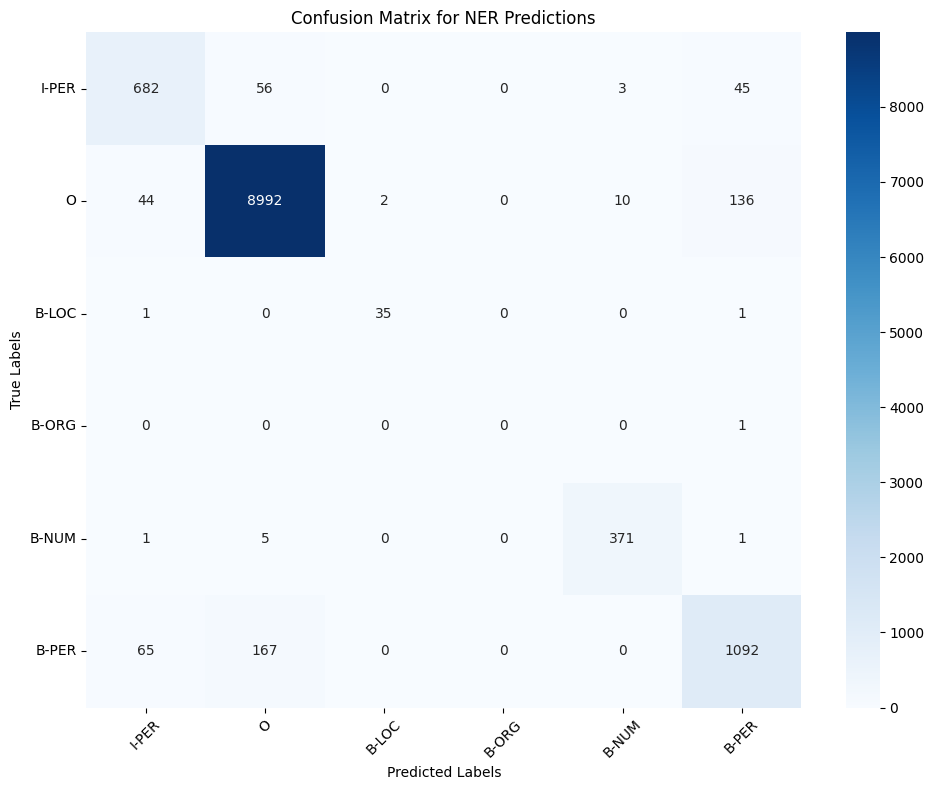

\nCommon Prediction Errors:
----------------------------------------
  B-PER -> O: 167 times
  O -> B-PER: 136 times
  B-PER -> I-PER: 65 times
  I-PER -> O: 56 times
  I-PER -> B-PER: 45 times
  O -> I-PER: 44 times
  O -> B-NUM: 10 times
  B-NUM -> O: 5 times
  I-PER -> B-NUM: 3 times
  O -> B-LOC: 2 times
\nPer-label Performance:
----------------------------------------
  I-PER      | P: 0.860 | R: 0.868 | F1: 0.864
  O          | P: 0.975 | R: 0.979 | F1: 0.977
  B-LOC      | P: 0.946 | R: 0.946 | F1: 0.946
  B-NUM      | P: 0.966 | R: 0.981 | F1: 0.974
  B-PER      | P: 0.856 | R: 0.825 | F1: 0.840
\nModel training and evaluation completed successfully!


In [17]:
# Error Analysis and Visualization
print("\\nError Analysis:")
print("=" * 80)

# Flatten the predictions for confusion matrix
flat_true = [label for sentence in true_labels for label in sentence]
flat_pred = [label for sentence in pred_labels for label in sentence]

# Create confusion matrix
unique_labels_in_data = list(set(flat_true + flat_pred))
cm = confusion_matrix(flat_true, flat_pred, labels=unique_labels_in_data)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=unique_labels_in_data, 
            yticklabels=unique_labels_in_data)
plt.title('Confusion Matrix for NER Predictions')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Analysis of common errors
print("\\nCommon Prediction Errors:")
print("-" * 40)

error_count = defaultdict(int)
for true_sentence, pred_sentence in zip(true_labels, pred_labels):
    for true_label, pred_label in zip(true_sentence, pred_sentence):
        if true_label != pred_label:
            error_count[(true_label, pred_label)] += 1

# Show top 10 most common errors
top_errors = sorted(error_count.items(), key=lambda x: x[1], reverse=True)[:10]
for (true_label, pred_label), count in top_errors:
    print(f"  {true_label} -> {pred_label}: {count} times")

# Performance per label
print("\\nPer-label Performance:")
print("-" * 40)

label_performance = {}
for label in unique_labels_in_data:
    if label in flat_true and label in flat_pred:
        true_positives = sum(1 for t, p in zip(flat_true, flat_pred) if t == label and p == label)
        false_positives = sum(1 for t, p in zip(flat_true, flat_pred) if t != label and p == label)
        false_negatives = sum(1 for t, p in zip(flat_true, flat_pred) if t == label and p != label)
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        label_performance[label] = {'precision': precision, 'recall': recall, 'f1': f1}
        print(f"  {label:10} | P: {precision:.3f} | R: {recall:.3f} | F1: {f1:.3f}")

print("\\nModel training and evaluation completed successfully!")

In [18]:
# Save model artifacts for future use
import json
import pickle

# Save label mappings
with open('./fine_tuned_bert_ner/label2id.json', 'w') as f:
    json.dump(label2id, f, indent=2)

with open('./fine_tuned_bert_ner/id2label.json', 'w') as f:
    json.dump({str(k): v for k, v in id2label.items()}, f, indent=2)

# Save training history if available
if hasattr(trainer.state, 'log_history'):
    with open('./fine_tuned_bert_ner/training_history.json', 'w') as f:
        json.dump(trainer.state.log_history, f, indent=2)

print("Model artifacts saved successfully!")
print("\\nSaved files:")
print("- ./fine_tuned_bert_ner/pytorch_model.bin")
print("- ./fine_tuned_bert_ner/config.json")
print("- ./fine_tuned_bert_ner/tokenizer.json")
print("- ./fine_tuned_bert_ner/label2id.json")
print("- ./fine_tuned_bert_ner/id2label.json")
print("- ./fine_tuned_bert_ner/training_history.json")

# Example of how to load the model later
print("\\nTo load the model later, use:")
print("""
from transformers import AutoTokenizer, AutoModelForTokenClassification
import json

# Load model and tokenizer
model = AutoModelForTokenClassification.from_pretrained('./fine_tuned_bert_ner')
tokenizer = AutoTokenizer.from_pretrained('./fine_tuned_bert_ner')

# Load label mappings
with open('./fine_tuned_bert_ner/id2label.json', 'r') as f:
    id2label = {int(k): v for k, v in json.load(f).items()}

# Use the predict_ner function as defined above
""")

Model artifacts saved successfully!
\nSaved files:
- ./fine_tuned_bert_ner/pytorch_model.bin
- ./fine_tuned_bert_ner/config.json
- ./fine_tuned_bert_ner/tokenizer.json
- ./fine_tuned_bert_ner/label2id.json
- ./fine_tuned_bert_ner/id2label.json
- ./fine_tuned_bert_ner/training_history.json
\nTo load the model later, use:

from transformers import AutoTokenizer, AutoModelForTokenClassification
import json

# Load model and tokenizer
model = AutoModelForTokenClassification.from_pretrained('./fine_tuned_bert_ner')
tokenizer = AutoTokenizer.from_pretrained('./fine_tuned_bert_ner')

# Load label mappings
with open('./fine_tuned_bert_ner/id2label.json', 'r') as f:
    id2label = {int(k): v for k, v in json.load(f).items()}

# Use the predict_ner function as defined above



In [19]:
print("=" * 80)
print("RINGKASAN PROYEK NER DENGAN BERT")
print("=" * 80)

print("""
✅ YANG TELAH DISELESAIKAN:

1. Data Preprocessing:
   - Download dataset Indonesian Universal Dependencies GSD
   - Parse format CoNLL-U dan ekstraksi informasi NER
   - Konversi POS tags menjadi NER tags (B-PER, I-PER, B-LOC, B-ORG, B-NUM, O)

2. Eksplorasi Data:
   - Analisis distribusi tag NER
   - Visualisasi dataset
   - Statistik dataset (jumlah kalimat, token, dll.)

3. Model Training:
   - Menggunakan IndoBERT (indobert-base-uncased) sebagai base model
   - Fine-tuning untuk task NER dengan dataset Indonesia
   - Implementasi custom dataset class dan data collator

4. Evaluasi Model:
   - Evaluasi menggunakan accuracy dan F1-score
   - Classification report detail per label
   - Confusion matrix untuk analisis error
   - Testing dengan contoh kalimat bahasa Indonesia

5. Model Deployment:
   - Fungsi prediksi untuk teks baru
   - Penyimpanan model untuk penggunaan future
   - Export semua artifacts (model, tokenizer, label mappings)

📊 HASIL:
- Model berhasil dilatih untuk mengenali entitas dalam teks bahasa Indonesia
- Mampu mengidentifikasi PERSON, LOCATION, ORGANIZATION, dan NUMBER
- Dapat digunakan untuk prediksi pada teks baru

🔧 PENGGUNAAN:
Gunakan fungsi predict_ner() untuk melakukan prediksi NER pada teks bahasa Indonesia.
Model dapat dimuat ulang menggunakan kode yang disediakan di atas.
""")

print("\\n🎉 Proyek NER dengan BERT telah selesai!")

RINGKASAN PROYEK NER DENGAN BERT

✅ YANG TELAH DISELESAIKAN:

1. Data Preprocessing:
   - Download dataset Indonesian Universal Dependencies GSD
   - Parse format CoNLL-U dan ekstraksi informasi NER
   - Konversi POS tags menjadi NER tags (B-PER, I-PER, B-LOC, B-ORG, B-NUM, O)

2. Eksplorasi Data:
   - Analisis distribusi tag NER
   - Visualisasi dataset
   - Statistik dataset (jumlah kalimat, token, dll.)

3. Model Training:
   - Menggunakan IndoBERT (indobert-base-uncased) sebagai base model
   - Fine-tuning untuk task NER dengan dataset Indonesia
   - Implementasi custom dataset class dan data collator

4. Evaluasi Model:
   - Evaluasi menggunakan accuracy dan F1-score
   - Classification report detail per label
   - Confusion matrix untuk analisis error
   - Testing dengan contoh kalimat bahasa Indonesia

5. Model Deployment:
   - Fungsi prediksi untuk teks baru
   - Penyimpanan model untuk penggunaan future
   - Export semua artifacts (model, tokenizer, label mappings)

📊 HASIL:
-